In [ ]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-93b56xwy
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-93b56xwy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-4d40l16r/pydoe_c0b1a438670c4ae0b602853f99f69330
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-4d40l16r/pydoe_c0b1a438670c4ae0b602853f99f69330
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from pyDOE import lhs

from scipy.stats.qmc import Sobol, Halton

from benchmark.bbobbenchmarks import F21, F16

from tqdm.notebook import tqdm, trange

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 2**6
verbose = False

space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
n_samples = 30000
samples = space.sample(n_samples)

obj_func = F21(1)

doe_budget = 0.1
doe_size = int(doe_budget * max_FEs)
values = obj_func(samples)

n_runs = 100

In [ ]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s')


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30, ax=None):
  if ax is None:
    ax = plt.gca()
  plot(samples, values, ax=ax, outline=False) # plot surface
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      ax.scatter(x, y, color="magenta", s=marker_size)
      ax.annotate(str(i), h)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s', marker_size=marker_size)

def plot_mult_performance(func, samples, values, results, marker_size=30):
    _, axs = plt.subplots(2, 2)
    for (ax, result) in zip(axs.flatten(), results):
      ax.title.set_text(result['title'])
      plot_ei_performance(func, samples, values, result['bo'], result, marker_size=30, ax=ax)

In [ ]:
def make_optimizer(obj_func, doe):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_all(doe, n=3, n_points=1000):
  regrets = []
  history = []
  precisions = []
  for seed in range(n):
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    regret = yopt - obj_func.getfopt()
    points = lhs(dim, n_points) * 10 - 5
    predicted_y = np.concatenate(bo.model.predict(points))
    real_y = obj_func(points)
    precision = np.mean((predicted_y - real_y)**2)
    precisions.append(precision)
    regrets.append(regret)
    history.append({'xopt': xopt, 'yopt': yopt, 'regret': regret, 'doe': doe, 'precision': precision, 'bo': bo})
  return np.concatenate(regrets).mean(), np.mean(precisions), history

def compute_all_for(f, n=10):
  precisions, regrets, history = [], [], []
  for _ in trange(n):
    doe = f()
    r, p, h = compute_all(doe, n=1, n_points=1000)
    precisions.append(p)
    regrets.append(r)
    history.append(h[0])
  return precisions, regrets, history

In [ ]:
def best_and_worst(history):
  def upd_min(t, c, f):
    if t is None:
      return c
    if t[f] > c[f]:
      return c
    return t
  def upd_max(t, c, f):
    if t is None:
      return c
    if t[f] < c[f]:
      return c
    return t
  best_regret, worst_regret = None, None
  best_precision, worst_precision = None, None
  for h in history:
    best_regret = upd_min(best_regret, h, 'regret')
    worst_regret = upd_max(worst_regret, h, 'regret')
    best_precision = upd_min(best_precision, h, 'precision')
    worst_precision = upd_max(worst_precision, h, 'precision')
  best_regret['title'] = 'min regret'
  worst_regret['title'] = 'max regret'
  best_precision['title'] = 'min precision'
  worst_precision['title'] = 'max precision'
  return best_regret, worst_regret, best_precision, worst_precision

# Latin hypercube sampling


In [ ]:
def generate_lhs():
  return lhs(2, doe_size) * 10 - 5

In [ ]:
lhs_precision, lhs_regret, lhs_history = compute_all_for(generate_lhs, n=n_runs)
print(f'LHS precision: {lhs_precision}, LHS regret: {lhs_regret}')

  0%|          | 0/100 [00:00<?, ?it/s]

LHS precision: [3062.896665223225, 3025.767481325783, 2984.6590058801094, 3098.211039580114, 3009.5748544787684, 3014.6068752761735, 3048.1154153859657, 3106.5620083409217, 3035.771222612181, 3054.7913895760285, 3076.801976498891, 3107.8784296017384, 3070.5097656394423, 3070.1929304541472, 3048.623342514179, 3008.2717352624686, 3003.2410458059567, 3058.3726979478593, 3130.6171005405113, 3037.7025627532366, 3012.996278430399, 3095.415167744347, 3006.0853788053755, 3081.8652883400773, 3005.7523661731234, 3075.456744441543, 3053.639911247087, 3050.9443545320164, 3005.3965256381134, 3031.3687712670508, 3081.9073541247017, 3129.547716941601, 3118.1423892188586, 3055.102246123232, 3040.9310355933085, 3138.1127555126827, 3060.96284502601, 3035.1356630154205, 3091.029530672171, 3074.819166535272, 3077.187948379814, 3093.197616666791, 3018.385892581281, 3076.5871552487524, 3126.2023680683205, 3043.944936042905, 3096.6742570032757, 3072.6579229911695, 3074.209167834879, 3098.2593285868484, 3026.

In [31]:
f'LHS precision: {np.mean(lhs_precision)}, Uniform regret: {np.mean(lhs_regret)}'

'LHS precision: 3061.005819094869, Uniform regret: 0.4294767977502'

LHS precision: min=2984.6590058801094 max=3138.1127555126827,  LHS regret: min=[1.6841414e-05], max=[2.40443187]


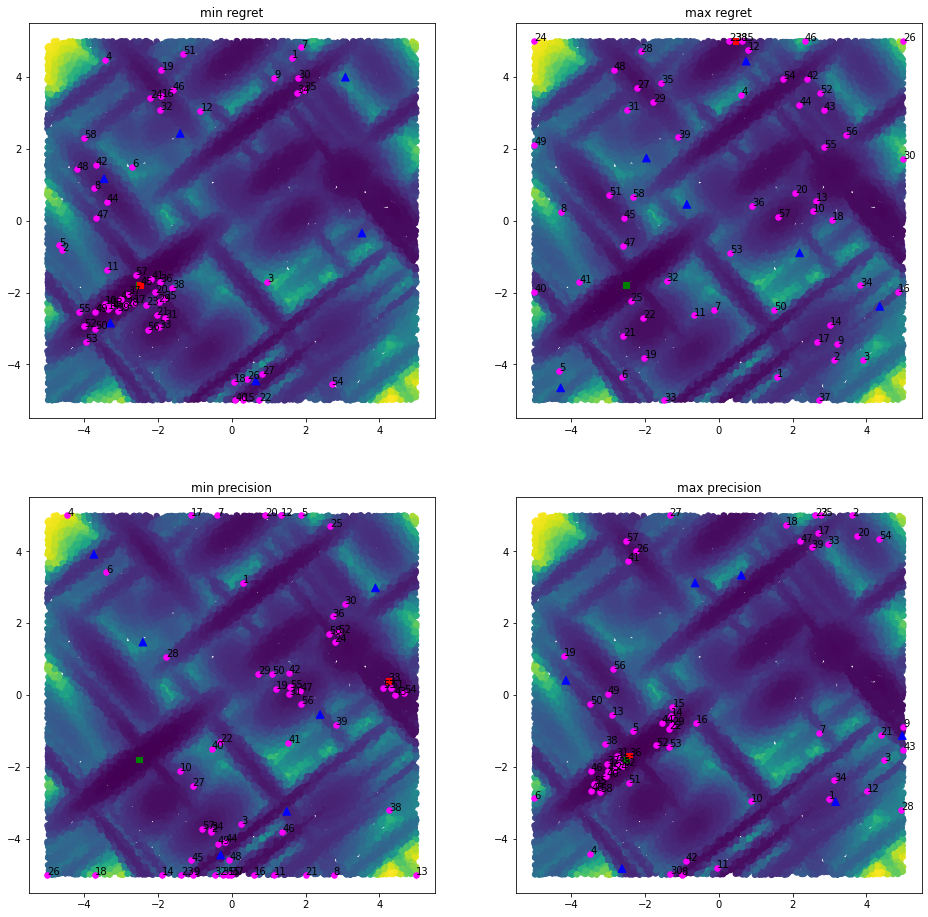

In [ ]:
plt.rcParams["figure.figsize"] = (16, 16)
lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision = best_and_worst(lhs_history)
print(f'LHS precision: min={lhs_best_precision["precision"]} max={lhs_worst_precision["precision"]},  LHS regret: min={lhs_best_regret["regret"]}, max={lhs_worst_regret["regret"]}')
plot_mult_performance(obj_func, samples, values, (lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision), marker_size=30)

In [43]:
lhs_best_precision['precision'], lhs_best_precision['regret']

(2984.6590058801094, array([0.97685365]))

In [44]:
lhs_best_regret['precision'], lhs_best_regret['regret']

(3004.013387120923, array([1.6841414e-05]))

# Uniform

In [ ]:
def generate_uniform():
  return np.random.uniform(-5, 5, (doe_size, 2))

In [10]:
uniform_precision, uniform_regret, uniform_history = compute_all_for(generate_uniform, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
f'Uniform precision: {np.mean(uniform_precision)}, Uniform regret: {np.mean(uniform_regret)}'

'Uniform precision: 3062.74912770064, Uniform regret: 0.5415537210080992'

Uniform precision: min=2987.2307164955578 max=3160.786545262403,  Uniform regret: min=[8.75817634e-07], max=[2.00204193]


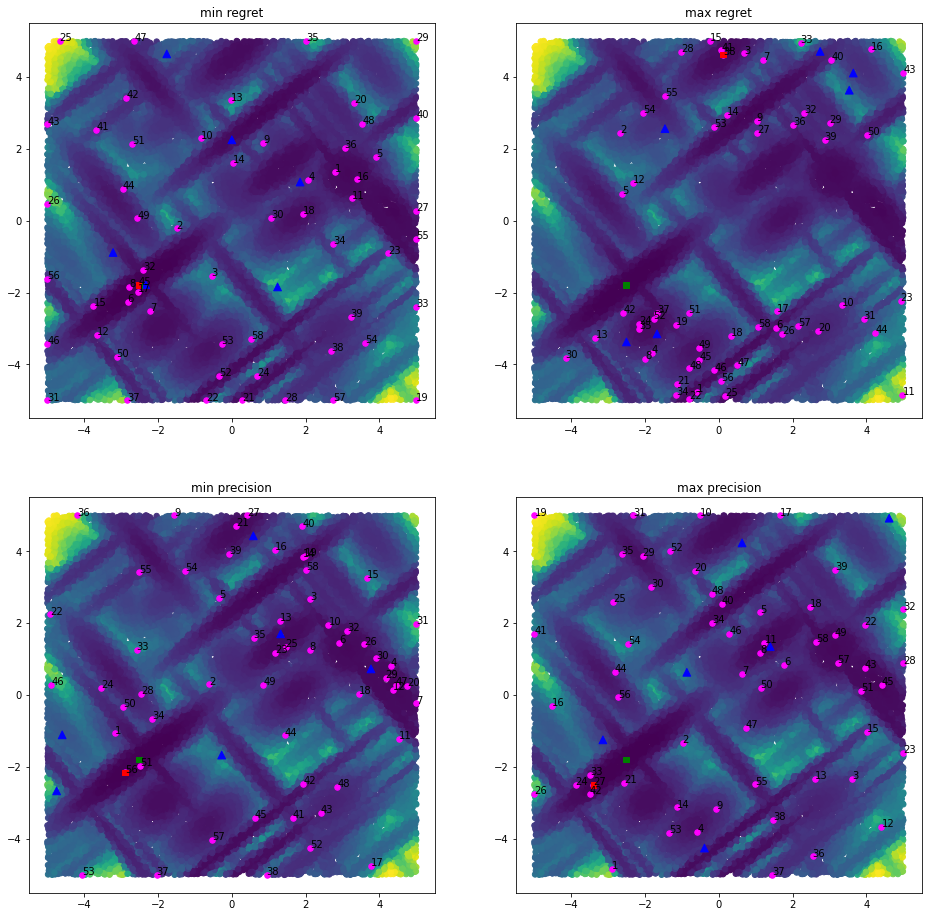

In [11]:
plt.rcParams["figure.figsize"] = (16, 16)
uniform_best_regret, uniform_worst_regret, uniform_best_precision, uniform_worst_precision = best_and_worst(uniform_history)
print(f'Uniform precision: min={uniform_best_precision["precision"]} max={uniform_worst_precision["precision"]},  Uniform regret: min={uniform_best_regret["regret"]}, max={uniform_worst_regret["regret"]}')
plot_mult_performance(obj_func, samples, values, (uniform_best_regret, uniform_worst_regret, uniform_best_precision, uniform_worst_precision), marker_size=30)

In [41]:
uniform_best_precision['precision'], uniform_best_precision['regret']

(2987.2307164955578, array([0.02100806]))

In [42]:
uniform_best_regret['precision'], uniform_best_regret['regret']

(3024.8815405417618, array([8.75817634e-07]))

# Sobol

In [12]:
def generate_sobol():
  return Sobol(dim).random(doe_size) * 10 - 5

In [13]:
sobol_precision, sobol_regret, sobol_history = compute_all_for(generate_sobol, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
f'Sobol precision: {np.mean(sobol_precision)}, Sobol regret: {np.mean(sobol_regret)}'

'Sobol precision: 3065.5886544127525, Sobol regret: 0.48840996530251923'

Sobol precision: min=2948.7460840121053 max=3156.0522088016096,  Sobol regret: min=[6.88547383e-06], max=[2.03176901]


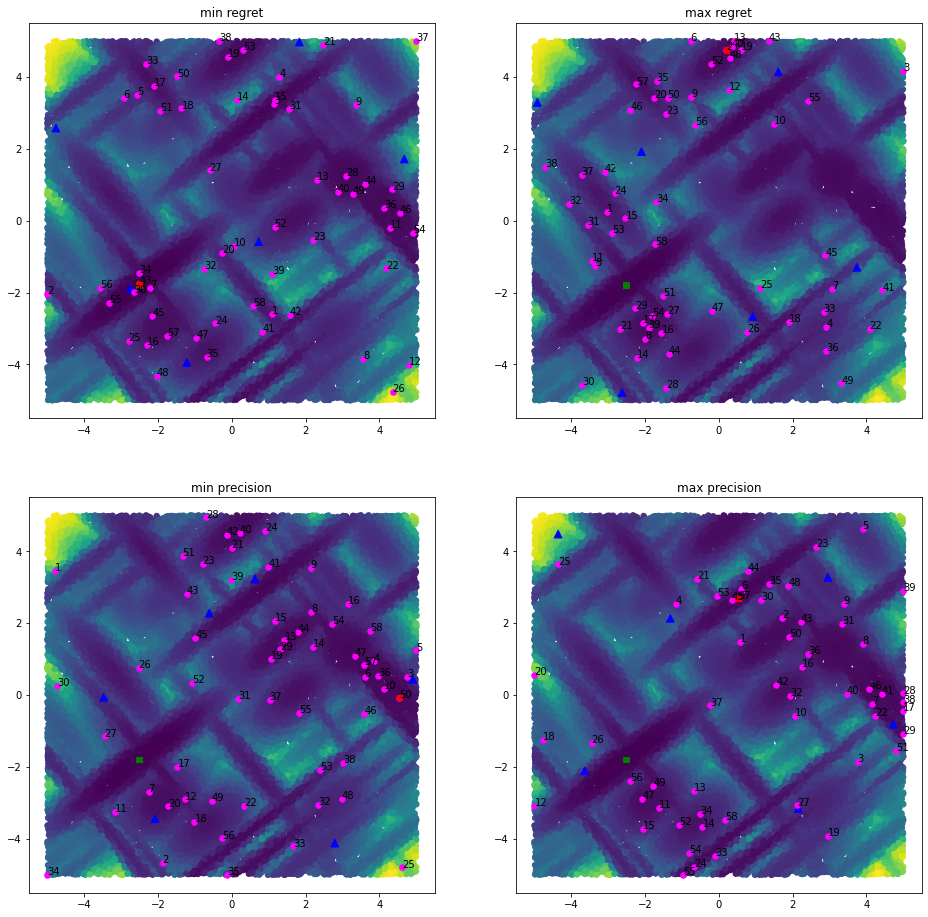

In [40]:
plt.rcParams["figure.figsize"] = (16, 16)
sobol_best_regret, sobol_worst_regret, sobol_best_precision, sobol_worst_precision = best_and_worst(sobol_history)
print(f'Sobol precision: min={sobol_best_precision["precision"]} max={sobol_worst_precision["precision"]},  Sobol regret: min={sobol_best_regret["regret"]}, max={sobol_worst_regret["regret"]}')
plot_mult_performance(obj_func, samples, values, (sobol_best_regret, sobol_worst_regret, sobol_best_precision, sobol_worst_precision), marker_size=30)

In [38]:
sobol_best_precision['precision'], sobol_best_precision['regret']

(2948.7460840121053, array([1.52893584]))

In [39]:
sobol_best_regret['precision'], sobol_best_regret['regret']

(3137.839723152155, array([6.88547383e-06]))

# Halton

In [ ]:
def generate_halton():
  return Halton(dim).random(doe_size) * 10 - 5

In [ ]:
halton_precision, halton_regret, halton_history = compute_all_for(generate_halton, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
f'Halton precision: {np.mean(halton_precision)}, Halton regret: {np.mean(halton_regret)}'

'Halton precision: 3056.219644656613, Halton regret: 0.4436854832626364'

Halton precision: min=2966.0559690017412 max=3153.2886224109234,  Halton regret: min=[5.4543392e-10], max=[2.07409435]


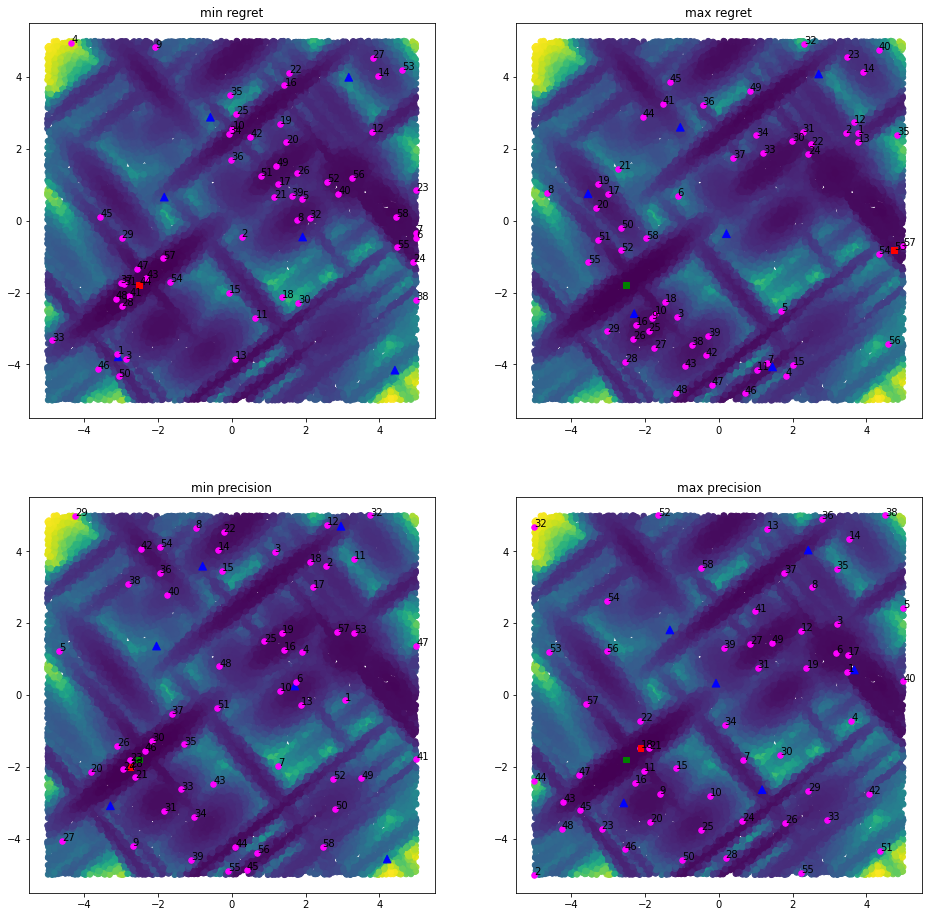

In [21]:
plt.rcParams["figure.figsize"] = (16, 16)
halton_best_regret, halton_worst_regret, halton_best_precision, halton_worst_precision = best_and_worst(halton_history)
print(f'Halton precision: min={halton_best_precision["precision"]} max={halton_worst_precision["precision"]},  Halton regret: min={halton_best_regret["regret"]}, max={halton_worst_regret["regret"]}')
plot_mult_performance(obj_func, samples, values, (halton_best_regret, halton_worst_regret, halton_best_precision, halton_worst_precision), marker_size=30)

In [37]:
halton_best_precision['precision'], halton_best_precision['regret']

(2966.0559690017412, array([0.00339184]))

In [35]:
halton_best_regret['precision'], halton_best_regret['regret']

(3061.546154790518, array([5.4543392e-10]))

# Compare

In [22]:
all_history = (lhs_history, uniform_history, sobol_history, halton_history)
all_titles = ("lhs", "uniform", "sobol", "halton")

## Regret boxplots

Text(0.5, 1.0, 'Regret')

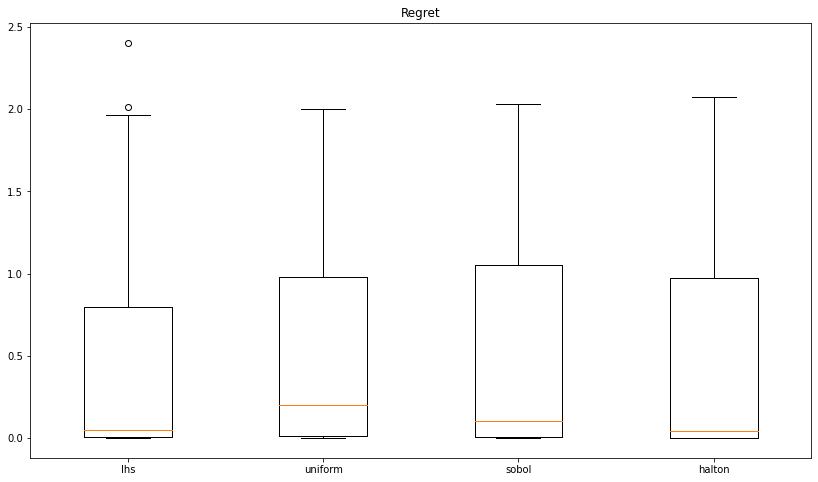

In [23]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [np.concatenate([result['regret'] for result in history]) for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), all_titles)
plt.title('Regret')

## Precision boxplots

Text(0.5, 1.0, 'Precision')

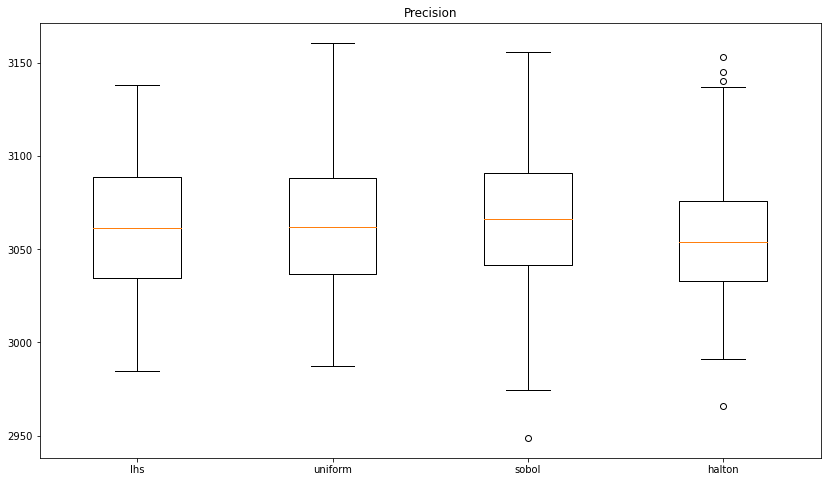

In [24]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [[result['precision'] for result in history] for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), ["lhs", "uniform", "sobol", "halton"])
plt.title('Precision')

## Regret-precision dep

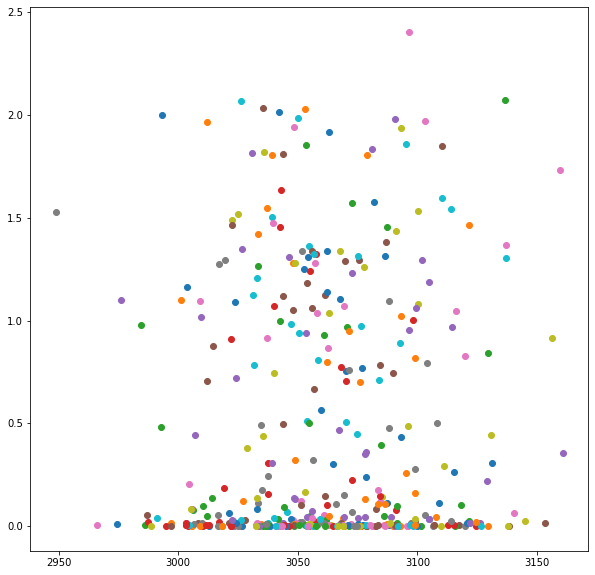

In [54]:
plt.rcParams["figure.figsize"] = (10, 10)
for info in (lhs_history + uniform_history + sobol_history + halton_history):
  plt.scatter(info['precision'], info['regret'])